# Proyecto Bimestral IIB
## Seguidor Solar
Fecha: 11/02/2025

### Realizado Por:
Correa Francisco, Yar Kenneth, Yanez Jorge 

Un seguidor solar es un sistema de orientación para maximizar la exposición a la luz solar. Esto se consigue cuando el panel se orienta perpendicularmente a la luz solar incidente. Cuando el panel no se encuentra perpendicular, la cantidad de energía generada disminuye significativamente.

### Objetivo:
[IMPORTANTE] Realizar el desarrollo matemático para calcular los 2 ángulos de control (
p
i
t
c
h
 y 
r
o
l
l
) en base a la posición solar (elevación 
θ
 y azimuth 
α
).
Implementar un programa que permita calcular los ángulos de control para un seguidor solar de 2 grados de libertad.
Dibujar la trayectoria del sol y del panel solar para un día determinado.
El panel solar debe ser perpendicular a la luz solar incidente.
El programa debe permitir ingresar la fecha y duración de la simulación, y graficar de manera interactiva la trayectoria del panel solar.
Realice un video de máximo 30 segundos del uso de su programa.

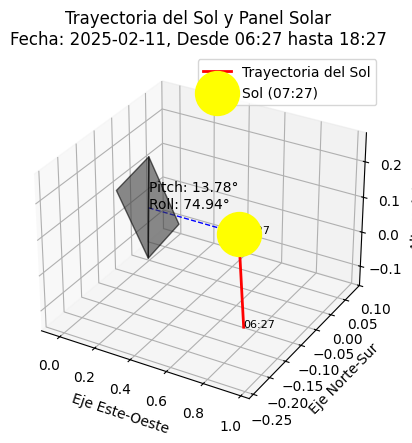

In [29]:
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk
from datetime import datetime, timedelta
from pytz import timezone
from pysolar.solar import get_altitude, get_azimuth
from astral import LocationInfo
from astral.sun import sun
import math
import os

# Calcula acimut y elevación del sol
def getSolarPosition(
    latitude: float = -0.2105367,
    longitude: float = -78.491614,
    date: datetime = datetime.now(tz=timezone("America/Guayaquil")),
):
    az = get_azimuth(latitude, longitude, date)
    el = get_altitude(latitude, longitude, date)
    return az, el

# Obtiene la hora de salida y puesta del sol
def get_sunrise_sunset(latitude, longitude, date):
    location = LocationInfo("Guayaquil", "Ecuador", "America/Guayaquil", latitude, longitude)
    s = sun(location.observer, date=date, tzinfo=timezone("America/Guayaquil"), dawn_dusk_depression=6)
    sunrise_adjusted = s['sunrise'] + timedelta(minutes=3.2)
    sunset_adjusted = s['sunset'] + timedelta(minutes=8.2)
    return sunrise_adjusted, sunset_adjusted

# Calcula los ángulos pitch y roll
def calculate_pitch_roll(azimuth, elevation):
    theta = math.radians(elevation)
    alpha = math.radians(azimuth)
    roll_rad = math.atan2(math.cos(theta) * math.sin(alpha), math.sin(theta))
    cos_roll = math.cos(roll_rad)
    if abs(cos_roll) < 1e-6:
        cos_roll = 1e-6
    pitch_rad = math.asin(-math.cos(theta) * math.cos(alpha))
    pitch = math.degrees(pitch_rad)
    roll = math.degrees(roll_rad)
    return pitch, roll

# Convierte azimut y elevación a coordenadas 3D
def spherical_to_cartesian(azimuths, elevations):
    azimuths_rad = np.radians(azimuths)
    elevations_rad = np.radians(elevations)
    sun_x = np.cos(elevations_rad) * np.sin(azimuths_rad)
    sun_y = np.cos(elevations_rad) * np.cos(azimuths_rad)
    sun_z = np.sin(elevations_rad)
    return sun_x, sun_y, sun_z

# Matriz de rotación para el panel
def rotate_panel(pitch, roll):
    pitch_rad = math.radians(pitch)
    roll_rad = math.radians(roll)
    rotation_x = np.array([
        [1, 0, 0],
        [0, math.cos(pitch_rad), -math.sin(pitch_rad)],
        [0, math.sin(pitch_rad), math.cos(pitch_rad)]
    ])
    rotation_y = np.array([
        [math.cos(roll_rad), 0, math.sin(roll_rad)],
        [0, 1, 0],
        [-math.sin(roll_rad), 0, math.cos(roll_rad)]
    ])
    return np.dot(rotation_x, rotation_y)

# Interfaz gráfica
def interactive_plot():
    root = tk.Tk()
    root.title("Configuración de la Simulación Solar")
    tk.Label(root, text="Latitud:").grid(row=0, column=0)
    lat_entry = tk.Entry(root)
    lat_entry.grid(row=0, column=1)
    lat_entry.insert(0, "-0.2105367")

    tk.Label(root, text="Longitud:").grid(row=1, column=0)
    lon_entry = tk.Entry(root)
    lon_entry.grid(row=1, column=1)
    lon_entry.insert(0, "-78.491614")

    tk.Label(root, text="Fecha (YYYY-MM-DD):").grid(row=2, column=0)
    date_entry = tk.Entry(root)
    date_entry.grid(row=2, column=1)
    date_entry.insert(0, datetime.now().strftime("%Y-%m-%d"))

    tk.Label(root, text="Duración (horas):").grid(row=3, column=0)
    duration_entry = tk.Entry(root)
    duration_entry.grid(row=3, column=1)
    duration_entry.insert(0, "12")

    sunrise_label = tk.Label(root, text="")
    sunrise_label.grid(row=5, column=0, columnspan=2)

    def update_sun_times():
        latitude = float(lat_entry.get())
        longitude = float(lon_entry.get())
        date = datetime.strptime(date_entry.get(), "%Y-%m-%d").date()
        sunrise, sunset = get_sunrise_sunset(latitude, longitude, date)
        sunrise_label.config(text=f"Salida del Sol: {sunrise.strftime('%H:%M')}  |  Puesta del Sol: {sunset.strftime('%H:%M')}")

    update_sun_times_button = tk.Button(root, text="Obtener Horas del Sol", command=update_sun_times)
    update_sun_times_button.grid(row=4, column=0, columnspan=2)

    def start_simulation():
        latitude = float(lat_entry.get())
        longitude = float(lon_entry.get())
        date = datetime.strptime(date_entry.get(), "%Y-%m-%d").date()
        duration = int(duration_entry.get())
        sunrise, sunset = get_sunrise_sunset(latitude, longitude, date)
        max_end_time = sunrise + timedelta(hours=duration)
        end_time = min(max_end_time, sunset)
        root.destroy()
        plotSunAndPanelTrajectoryInWindow(sunrise, end_time, latitude, longitude)

    start_button = tk.Button(root, text="Iniciar Simulación", command=start_simulation)
    start_button.grid(row=6, column=0, columnspan=2)
    root.mainloop()

# Dibuja la trayectoria del sol y la posición del panel
def plotSunAndPanelTrajectoryInWindow(start_time, end_time, latitude, longitude):
    times = []
    current_time = start_time
    while current_time <= end_time:
        times.append(current_time)
        current_time += timedelta(hours=1)
    azimuths, elevations = zip(*[getSolarPosition(latitude, longitude, time) for time in times])
    sun_x, sun_y, sun_z = spherical_to_cartesian(azimuths, elevations)

    panel_x, panel_y, panel_z = 0, 0, 0
    root = tk.Tk()
    root.title("Trayectoria del Sol y Panel Solar")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    def update_plot(i=0):
        if i < len(sun_x):
            ax.clear()
            ax.plot(sun_x[:i+1], sun_y[:i+1], sun_z[:i+1], label='Trayectoria del Sol', color='red', linewidth=2)
            sun_size = 1000 
            ax.scatter(sun_x[i], sun_y[i], sun_z[i], color='yellow', s=sun_size, label=f'Sol ({times[i].strftime("%H:%M")})')
            pitch, roll = calculate_pitch_roll(azimuths[i], elevations[i])
            panel_width, panel_height = 0.25, 0.1
            panel_corners = np.array([
                [-panel_width / 2, -panel_height / 2, 0],
                [ panel_width / 2, -panel_height / 2, 0],
                [ panel_width / 2,  panel_height / 2, 0],
                [-panel_width / 2,  panel_height / 2, 0]
            ])
            rotation_matrix = rotate_panel(pitch, roll)
            rotated_panel = np.dot(panel_corners, rotation_matrix.T)
            rotated_panel[:, 0] += panel_x
            rotated_panel[:, 1] += panel_y
            rotated_panel[:, 2] += panel_z
            px, py, pz = rotated_panel.T
            ax.plot_trisurf(px, py, pz, color='gray', alpha=0.6, edgecolor='black')
            ax.plot([panel_x, sun_x[i]], [panel_y, sun_y[i]], [panel_z, sun_z[i]], color='blue', linestyle='dashed', linewidth=1)
            for j in range(i + 1):
                ax.text(sun_x[j], sun_y[j], sun_z[j], times[j].strftime('%H:%M'), fontsize=8, color='black')
            ax.text(panel_x, panel_y, panel_z, f"Pitch: {pitch:.2f}°\nRoll: {roll:.2f}°", fontsize=10, color='black')
            ax.set_xlabel('Eje Este-Oeste')
            ax.set_ylabel('Eje Norte-Sur')
            ax.set_zlabel('Altura (Eje Z)')
            ax.set_title(f'Trayectoria del Sol y Panel Solar\nFecha: {start_time.strftime("%Y-%m-%d")}, Desde {start_time.strftime("%H:%M")} hasta {end_time.strftime("%H:%M")}')
            ax.legend()
            canvas.draw()
            root.after(500, update_plot, i + 1)
        else:
            root.after(1000, update_plot, 0)

    update_plot()
    root.mainloop()

if __name__ == "__main__":
    interactive_plot()

